## Prepare

### Install dependencies
- `fastai` - machine learning library
- `librosa` - open `.wav` files and convert to spectrograms
- `matplotlib` - plot waveforms and save generated spectrograms as `.png` files

In [ ]:
!pip3 install fastai librosa matplotlib

### Download the training dataset

Source: https://magenta.tensorflow.org/datasets/nsynth

We only download the validation set, of 12k examples rather than the substantially larger training set, as it's a sufficient amount of data to experiment with. Download to the `training-data` directory in the root of the repository, so it can be shared by other projects and it is also part of `.gitignore`.

In [ ]:
import requests

url = 'http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz'
response = requests.get(url)

with open('../../training-data/nsynth-test.jsonwav.tar.gz', 'wb') as f:
    f.write(response.content)

### Extract the downloaded dataset

In [8]:
import tarfile

with tarfile.open('../../training-data/nsynth-valid.jsonwav.tar.gz', 'r:gz') as f:
    f.extractall('../../training-data/')

### Load the example metadata

The metadata is located in `examples.json` in the extracted directory.

In [34]:
import json

examples = []
with open('../../training-data/nsynth-valid/examples.json') as f:
    examples = json.load(f)

first_20_examples = dict(list(examples.items())[:20])
first_example = list(examples.items())[0][1]

### Plot the first waveform spectrogram

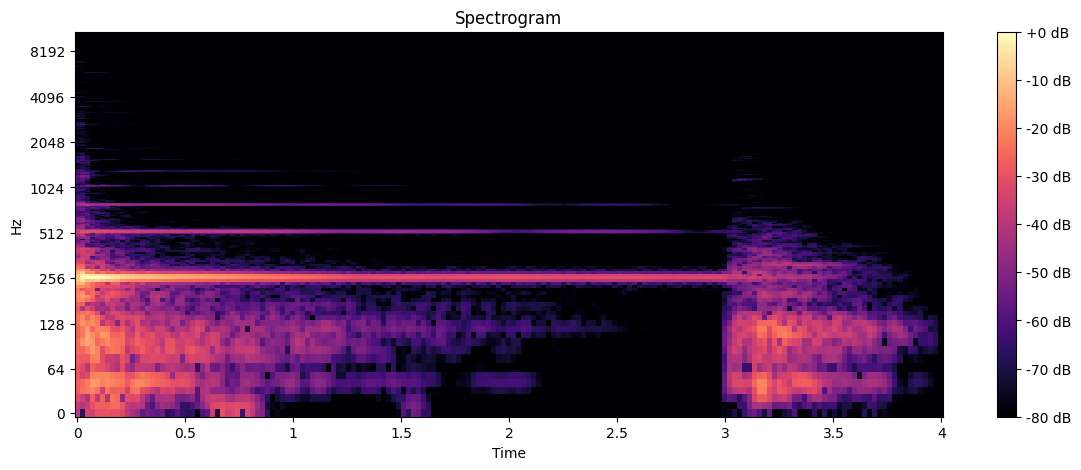

In [34]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
y, sample_rate = librosa.load('../../training-data/nsynth-valid/audio/' + first_example['note_str'] + '.wav')

# Compute the STFT
D = librosa.stft(y)

# Convert to dB
D_db = librosa.amplitude_to_db(abs(D), ref=np.max)

# Display the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(D_db, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

### Store spectrogram images

`fastai` is designed to work with image data, and machine vision algorithms transfer quite well to audio spectrograms. Therefore, we prepare our data by storing spectrogram images alongside the audio files.

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

os.makedirs('../../training-data/nsynth-valid/spectrograms', exist_ok=True)

for key, _ in examples.items():
    # Load the audio file
    y, sr = librosa.load('../../training-data/nsynth-valid/audio/' + key + '.wav')

    # Compute the STFT
    D = librosa.stft(y)

    # Convert to dB
    D_db = librosa.amplitude_to_db(abs(D), ref=np.max)

    # Get the shape of the data
    height, width = D_db.shape

    # Create a figure with size equal to the shape of the data
    plt.figure(figsize=(width, height), dpi=1, layout='tight', frameon=False)
    plt.axis('off')

    # Display the spectrogram
    librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log')

    # Save the figure with dpi=1
    plt.savefig('../../training-data/nsynth-valid/spectrograms/' + key + '.png', bbox_inches='tight', pad_inches=0)
    plt.close()

## Predict instrument based on spectrogram

### Create the DataLoaders

In this first example, we will predict the instrument family based on the spectrogram image. We create `DataLoaders` that map the spectrogram image data to category data for the instrument category.

In [35]:
from fastai.vision.all import *

def get_instrument_family(path):
    filename = os.path.basename(path)[:-4]
    example = examples[filename]
    return example['instrument_family_str']

instrument_dls = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_instrument_family
).dataloaders("../../training-data/nsynth-valid/spectrograms/", bs=64)

In [36]:
xs, ys = instrument_dls.one_batch()

# Input batch size is 64 and each image is 1024x172 pixels
# with three colour channels. Therefore we expect xs to have
# shape (64, 3, 172, 1024) and ys to have shape (64,).
xs.shape, ys.shape

(torch.Size([64, 3, 1024, 172]), torch.Size([64]))

### Show one batch of data

Next, we confirm that the data is being loaded correctly. We expect to see spectrograms with their instrument labels.

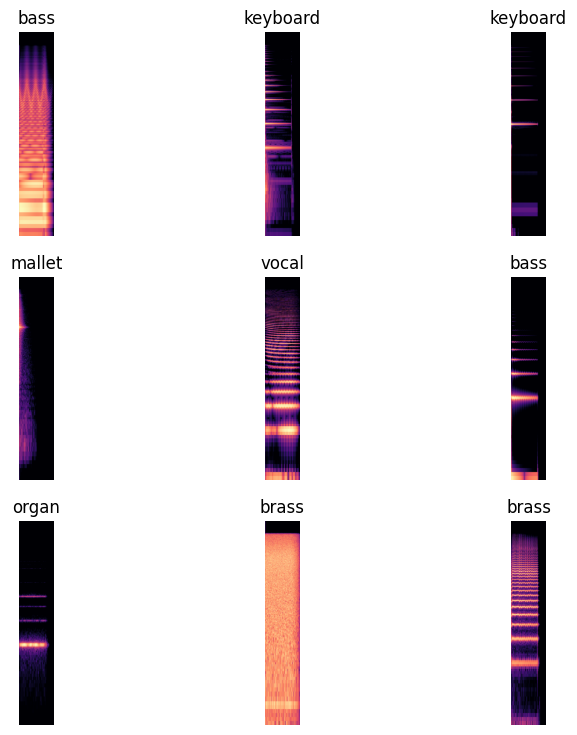

In [323]:
instrument_dls.show_batch()

### Fit the model

We simply use a `resnet34` model as a starting point.

In [23]:
instrument_learner = vision_learner(instrument_dls, resnet34, metrics=error_rate)
instrument_learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.268163,0.301392,0.089546,04:22
1,0.268829,0.059755,0.017357,04:24
2,0.099671,0.028603,0.009862,04:22
3,0.056096,0.010125,0.001972,04:22
4,0.038010,0.008345,0.002761,04:22
5,0.020890,0.003364,0.000394,04:22
6,0.012525,0.001509,0.000789,04:22
7,0.009295,0.001324,0.000000,04:22
8,0.004983,0.000759,0.000000,04:23
9,0.004141,0.000727,0.000000,04:22


### Test it against the first 20 examples

In [25]:
for example, data in first_20_examples.items():
    image = PILImage.create('../../training-data/nsynth-valid/spectrograms/' + example + '.png')
    actual_category = data['instrument_family_str']
    predicted_category, _, _ = instrument_learner.predict(image)
    print(f'Predicted: {predicted_category}, Actual: {actual_category}')

Predicted: keyboard, Actual: keyboard


Predicted: bass, Actual: bass


Predicted: bass, Actual: bass


Predicted: keyboard, Actual: keyboard


Predicted: bass, Actual: bass


Predicted: bass, Actual: bass


Predicted: bass, Actual: bass


Predicted: mallet, Actual: mallet


Predicted: organ, Actual: organ


Predicted: keyboard, Actual: keyboard


Predicted: organ, Actual: organ


Predicted: brass, Actual: brass


Predicted: keyboard, Actual: keyboard


Predicted: bass, Actual: bass


Predicted: organ, Actual: organ


Predicted: guitar, Actual: guitar


Predicted: bass, Actual: bass


Predicted: bass, Actual: bass


Predicted: string, Actual: string


Predicted: organ, Actual: organ


## Predict audio qualities based on spectrogram

Next, we explore the "qualities" of the audio samples, where each audio sample can belong to multiple categories ('dark', 'reverb', etc.). Instead of a `CategoryBlock`, we use a `MultiCategoryBlock`. This will ensure that `fastai` uses a binary cross-entropy loss function under the hood.

In [35]:
def get_qualities(path):
    filename = os.path.basename(path)[:-4]
    example = examples[filename]
    return example['qualities_str']

qualities_dls = DataBlock(
    blocks=(ImageBlock(), MultiCategoryBlock()),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_qualities
).dataloaders("../../training-data/nsynth-valid/spectrograms/", bs=64)

Check that our data batches look sensible:

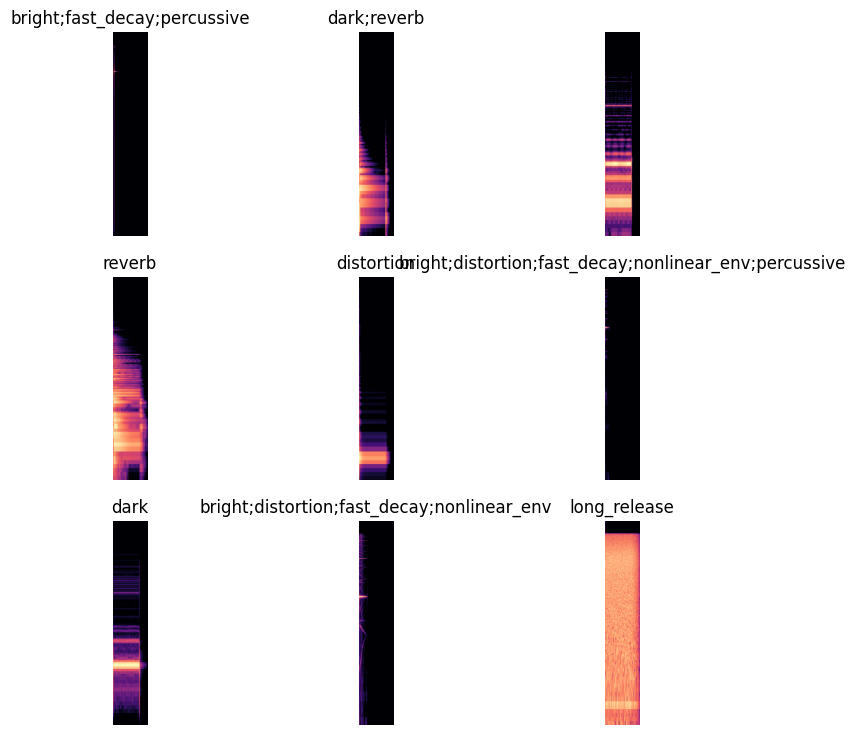

In [36]:
qualities_dls.show_batch()

Next, fit the model. We first fit the head of the model, and then unfreeze and fine-tune the whole model, since there is no reason to expect that many of the features applicable to image classification carry over to spectrogram classification.

In [11]:
qualities_learner = vision_learner(qualities_dls, resnet34, metrics=partial(accuracy_multi, thresh=0.5))
qualities_learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.752366,0.474752,0.783235,04:26
1,0.340786,0.137869,0.970769,04:25
2,0.115411,0.055243,0.982367,04:24
3,0.071737,0.041886,0.985247,04:25
4,0.055520,0.033711,0.987377,04:24
5,0.043421,0.027345,0.990059,04:24
6,0.037145,0.024406,0.991400,04:24
7,0.030471,0.022036,0.992505,04:24
8,0.028169,0.022198,0.992387,04:24
9,0.026044,0.021798,0.992387,04:24


In [13]:
qualities_learner.unfreeze()
qualities_learner.fit_one_cycle(10, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.030820,0.026358,0.990690,06:13
1,0.038834,0.032095,0.988600,06:10
2,0.032881,0.025050,0.990375,06:10
3,0.023532,0.022263,0.992899,06:09
4,0.017340,0.018189,0.993609,06:10
5,0.011876,0.015152,0.995306,06:10
6,0.006878,0.013702,0.995266,06:09
7,0.004465,0.011282,0.996016,06:10
8,0.002703,0.011978,0.995858,06:10
9,0.002031,0.011565,0.996095,06:10


## Combininig the two models

We now have pretty great performance on predicting the instrument and audio qualities of our samples. However, we have two separate models doing the work. There is a good reason to think that many of the features in the first layers of the neural network are transferrable to both categorisation problems. Why not combine them into a single model?

We'll have to do a bit more low-level work here, because `fastai` doesn't know how to deal with multiple kinds of output. We start by defining the vocabularies for our two sets of categories:

In [1]:
instrument_vocab = ['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'synth_lead', 'vocal']
qualities_vocab = ['bright', 'dark', 'distortion', 'fast_decay', 'long_release', 'multiphonic', 'nonlinear_env', 'percussive', 'reverb', 'tempo-synced']

### Building the Dataset

To make things interesting, in this example, we'll write our own `Dataset` implementation, which will load the `.wav` files and transform them to spectrograms rather than loading the `.png` files.

In [ ]:
from torch.utils.data import Dataset
import torch.nn.functional as F
import json
import random
from fastai.vision.all import *
import librosa

class SpectrogramDataset(Dataset):
    def __init__(self, path, examples=None, seed=42):
        self.path = path
        if examples is None:
            self.examples = list(json.load(open(f'{path}/examples.json')).items())
            self.examples.sort(key=lambda x: x[0])
        else:
            self.examples = examples
        if seed is not None:
            rng = random.Random(seed)
            rng.shuffle(self.examples)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return SpectrogramDataset(
                self.path, examples=self.examples[idx], seed=None)
        else:
            example = self.examples[idx]
            y, _ = librosa.load(f'{self.path}/audio/{example[0]}' + '.wav')
            ft = librosa.stft(y)
            ft_db = librosa.amplitude_to_db(abs(ft), ref=np.max)

            # Convert to PyTorch tensor and add a channel dimension
            input_tensor = tensor(ft_db).unsqueeze(0).to(default_device())

            instrument_family = example[1]['instrument_family']
            instrument_tensor = F.one_hot(tensor(instrument_family).to(default_device()), 11)

            qualities_tensor = tensor(example[1]['qualities']).to(default_device())
            target_tensor = torch.concat((instrument_tensor, qualities_tensor)).to(default_device())
            return input_tensor.float(), target_tensor.float()


### Create the DataLoaders

In [37]:
ds = SpectrogramDataset('../../training-data/nsynth-valid')
ds_length = len(ds)

## Split the dataset into training and validation sets
train_ds = ds[:int(ds_length * 0.8)]
valid_ds = ds[int(ds_length * 0.8):]

combined_dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=32, batch_tfms=IntToFloatTensor)

### Check the DataLoaders

We've done a bit more low-level work this time and `fastai` doesn't know how to render our data batches automatically. We'll have to write our own code to display some examples to check they look sensible.

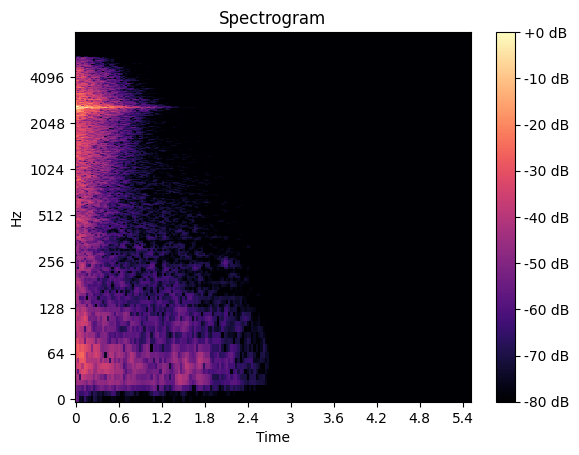

Instrument: mallet
Qualities: ['fast_decay', 'percussive', 'reverb']


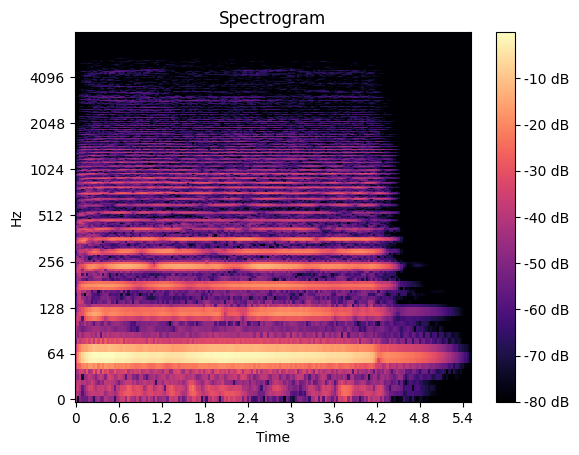

Instrument: string
Qualities: ['long_release', 'reverb']


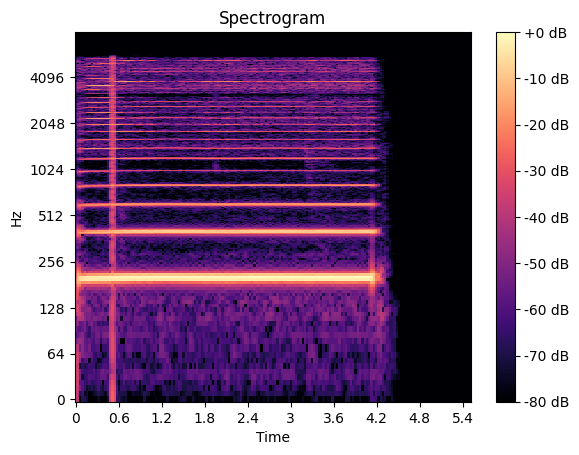

Instrument: brass
Qualities: ['bright']


In [39]:
import matplotlib.pyplot as plt

xs, ys = combined_dls.one_batch()
for idx in range(3):
    x, y = xs[idx][0], ys[idx]
    
    librosa.display.specshow(np.array(x.to('cpu')), sr=16000, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

    instrument = instrument_vocab[torch.argmax(y[:11])]
    print(f'Instrument: {instrument}')

    qualitities = map(lambda quality: qualities_vocab[quality], (y[11:]>0.5).nonzero())
    print(f'Qualities: {list(qualitities)}')

### Define the loss function

We need to combine the instrument category loss, with the qualities multi-category loss. These are partially independent, so we can just add them together, and our learner will optimise both.

We also need to define separate accuracy metrics for our instrument classification and our qualities classification.

In [8]:
import torch.nn as nn

cross_entropy_loss = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss()

def loss_func(activs, targ):
    # Split the activations and targets into instrument and qualities
    instrument_activs = activs[:, :len(instrument_vocab)]
    instrument_targ = targ[:, :len(instrument_vocab)]
    qualities_activs = activs[:, len(instrument_vocab):]
    qualities_targ = targ[:, len(instrument_vocab):]

    # Calculate the losses
    instrument_loss = cross_entropy_loss(instrument_activs, instrument_targ)
    qualities_loss = bce_loss(qualities_activs, qualities_targ)

    # Return the sum of the losses
    return instrument_loss + qualities_loss

def accuracy_qualities(inp, targ, thresh=0.5, sigmoid=True):
    return accuracy_multi(
        inp[:, len(instrument_vocab):], targ[:, len(instrument_vocab):], thresh, sigmoid)

def accuracy_instrument(inp, targ):
    return accuracy(
        inp[:, :len(instrument_vocab)], targ[:, :len(instrument_vocab)].argmax(dim=1))

In [10]:
learn = vision_learner(dls, resnet34, n_out=21, loss_func=loss_func, metrics=[accuracy_instrument, accuracy_qualities])

# Adjust first layer
first_layer = list(learn.model.children())[0][0]
new_first_layer = nn.Conv2d(1, first_layer.out_channels, 
                            kernel_size=first_layer.kernel_size[0], 
                            stride=first_layer.stride[0], 
                            padding=first_layer.padding[0])

learn.model[0][0] = new_first_layer

learn.model = learn.model.to(default_device())

In [11]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy_instrument,accuracy_qualities,time
0,1.181145,8.304587,0.312697,0.296254,05:08
1,0.458002,0.255419,0.969243,0.943494,05:02
2,0.299126,0.159824,0.983833,0.961987,05:02


In [31]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy_instrument,accuracy_qualities,time
0,0.340240,0.415707,0.917587,0.944203,06:30
1,0.241569,0.144670,0.973975,0.971964,18:30
2,0.138233,0.079730,0.990142,0.980876,06:29
3,0.090858,0.058506,0.998028,0.982650,06:29
4,0.050438,0.036314,0.998817,0.989077,06:29
5,0.043763,0.032046,0.998817,0.990931,06:29


In [32]:
examples = list(json.load(open('../../training-data/nsynth-valid/examples.json')).items())[:10]

In [33]:
for example in examples:
    y, _ = librosa.load(f'../../training-data/nsynth-valid/audio/{example[0]}.wav')
    ft = librosa.stft(y)
    ft_db = librosa.amplitude_to_db(abs(ft), ref=np.max)
    input_tensor = tensor(ft_db).unsqueeze(0).unsqueeze(0).to(default_device())

    output_tensor, _, _ = learn.predict(input_tensor.float())
    instrument_output = output_tensor[:11]
    qualities_output = output_tensor[11:]

    instrument = instrument_vocab[torch.argmax(instrument_output)]
    print(f'Actual instrument: {example[1]["instrument_family_str"]}, predicted instrument: {instrument}')

    qualitities = map(lambda quality: qualities_vocab[quality], (qualities_output>0.5).nonzero())
    print(f'Actual qualities: {example[1]["qualities_str"]}')
    print(f'Predicted qualities: {list(qualitities)}')

Actual instrument: keyboard, predicted instrument: keyboard
Actual qualities: ['dark', 'reverb']
Predicted qualities: ['dark', 'reverb']


Actual instrument: bass, predicted instrument: bass
Actual qualities: ['dark']
Predicted qualities: ['dark']


Actual instrument: bass, predicted instrument: bass
Actual qualities: ['bright', 'distortion', 'long_release']
Predicted qualities: ['bright', 'distortion', 'long_release']


Actual instrument: keyboard, predicted instrument: keyboard
Actual qualities: []
Predicted qualities: []


Actual instrument: bass, predicted instrument: bass
Actual qualities: ['distortion', 'tempo-synced']
Predicted qualities: ['distortion', 'tempo-synced']


Actual instrument: bass, predicted instrument: bass
Actual qualities: ['dark']
Predicted qualities: ['dark']


Actual instrument: bass, predicted instrument: bass
Actual qualities: ['bright', 'distortion', 'long_release']
Predicted qualities: ['bright', 'distortion', 'long_release']


Actual instrument: mallet, predicted instrument: mallet
Actual qualities: ['dark', 'multiphonic']
Predicted qualities: ['dark', 'multiphonic']


Actual instrument: organ, predicted instrument: organ
Actual qualities: ['dark']
Predicted qualities: ['dark']


Actual instrument: keyboard, predicted instrument: keyboard
Actual qualities: []
Predicted qualities: []
